In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/cats vs dogs.zip'

In [ ]:
import shutil
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
from io import BytesIO
from ipywidgets import widgets

In [ ]:
original_dir = '/content/PetImages'
new_base_dir = '/content/Cats_vs_Dogs'
os.makedirs(new_base_dir, exist_ok=True)

In [ ]:
# Create train/test directories
train_dir = os.path.join(new_base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
test_dir = os.path.join(new_base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Create class subdirectories
train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir, exist_ok=True)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir, exist_ok=True)

test_cats_dir = os.path.join(test_dir, 'cats')
os.makedirs(test_cats_dir, exist_ok=True)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.makedirs(test_dogs_dir, exist_ok=True)

In [ ]:
cat_images = [img for img in os.listdir('/content/PetImages/Cat') if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
dog_images = [img for img in os.listdir('/content/PetImages/Dog') if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

In [ ]:
train_cats = random.sample(cat_images, 1000)
train_dogs = random.sample(dog_images, 1000)

remaining_cats = [img for img in cat_images if img not in train_cats]
remaining_dogs = [img for img in dog_images if img not in train_dogs]

test_cats = random.sample(remaining_cats, 500)
test_dogs = random.sample(remaining_dogs, 500)

In [ ]:
def copy_images(file_list, src_dir, dest_dir):
    for img in file_list:
        src_path = os.path.join(src_dir, img)
        dest_path = os.path.join(dest_dir, img)
        shutil.copyfile(src_path, dest_path)



copy_images(train_cats, '/content/PetImages/Cat', train_cats_dir)
copy_images(train_dogs, '/content/PetImages/Dog', train_dogs_dir)

copy_images(test_cats, '/content/PetImages/Cat', test_cats_dir)
copy_images(test_dogs, '/content/PetImages/Dog', test_dogs_dir)

In [ ]:
# now our dataset is created successfully
print(f'total training cat images: {len(os.listdir(train_cats_dir))}')
print(f'total training dog images: {len(os.listdir(train_dogs_dir))}')

print(f'total validation cat images: {len(os.listdir(test_cats_dir))}')
print(f'total validation dog images: {len(os.listdir(test_dogs_dir))}')

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(f"5 files in cats subdir: {train_cat_fnames[:5]}")
print(f"5 files in dogs subdir: {train_dog_fnames[:5]}")

5 files in cats subdir: ['12272.jpg', '6530.jpg', '2330.jpg', '9665.jpg', '12233.jpg']
5 files in dogs subdir: ['9008.jpg', '2813.jpg', '4711.jpg', '1914.jpg', '8867.jpg']


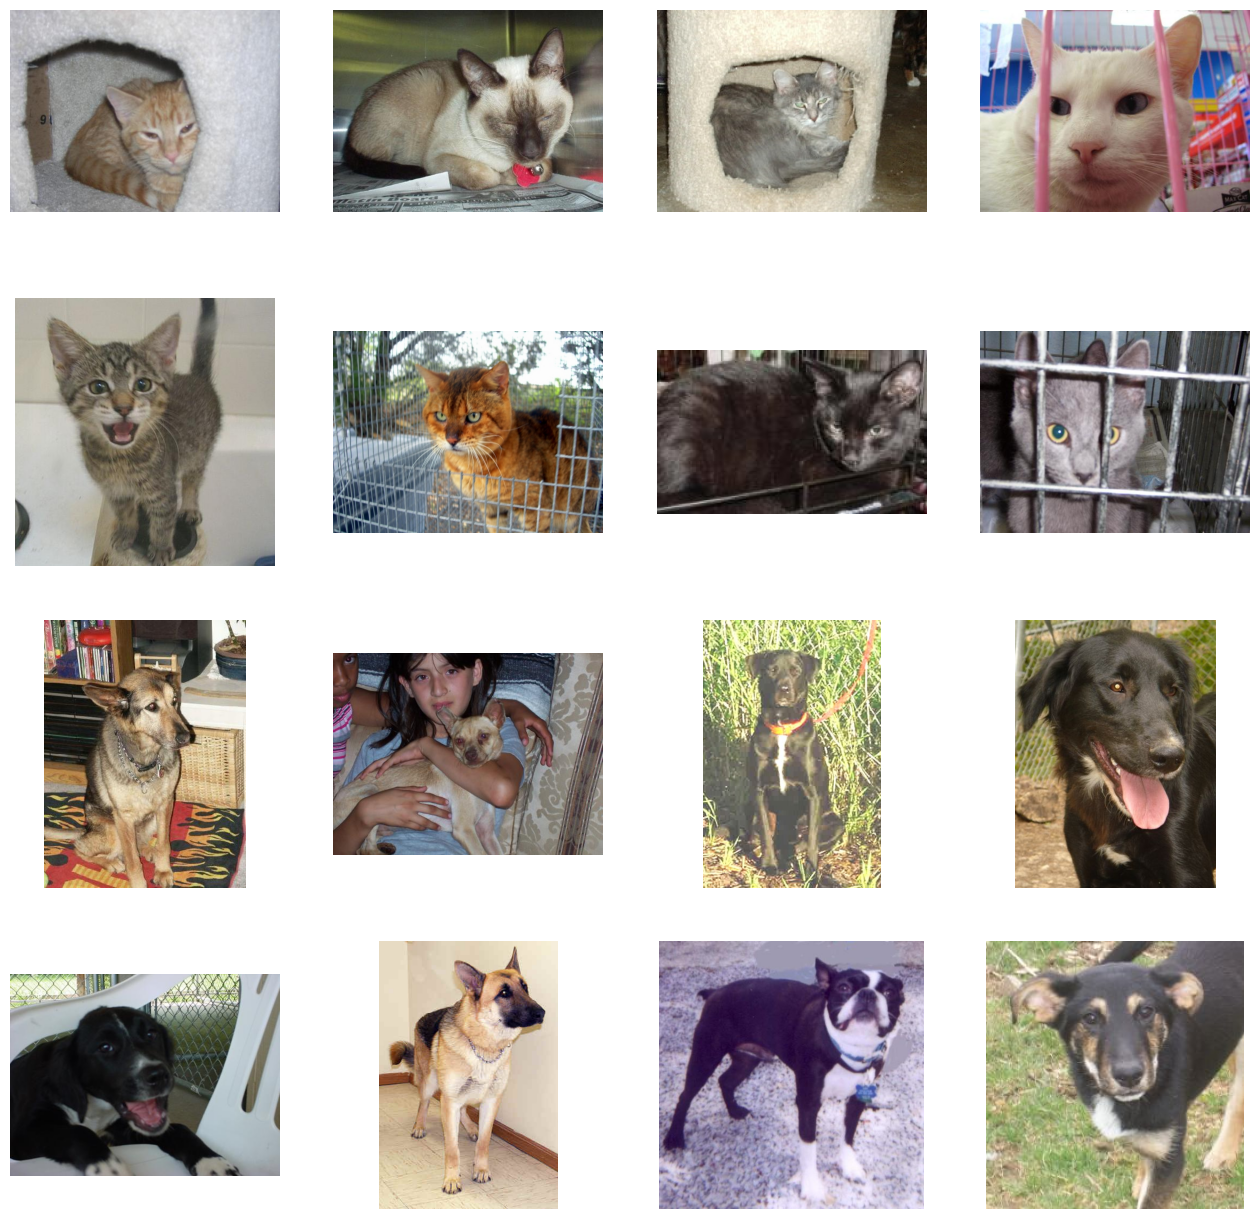

In [ ]:
# Parameters for your graph; you will output images in a 4x4 configuration
nrows = 4
ncols = 4

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in random.sample(train_cat_fnames, k=8)]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in random.sample(train_dog_fnames, k=8)]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [ ]:
model = tf.keras.models.Sequential([
    # Rescale the image. Note the input shape is the desired size of the image: 150x150 with 3 bytes for color
    tf.keras.Input(shape=(150, 150, 3)),
    tf.keras.layers.Rescaling(1./255),
    # Convolution and Pooling layers
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for one class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size = (150,150),
    batch_size = 20,
    shuffle = True
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size = (150,150),
    batch_size = 20,
    shuffle = True
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = train_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
validation_dataset_final = test_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)

In [ ]:
history = model.fit(
    train_dataset_final,
    epochs = 15,
    validation_data = validation_dataset_final,
    verbose = 2
)

Epoch 1/15
100/100 - 72s - 724ms/step - accuracy: 0.5405 - loss: 0.7298 - val_accuracy: 0.5840 - val_loss: 0.6844
Epoch 2/15
100/100 - 77s - 766ms/step - accuracy: 0.6195 - loss: 0.6681 - val_accuracy: 0.6330 - val_loss: 0.6327
Epoch 3/15
100/100 - 62s - 616ms/step - accuracy: 0.6840 - loss: 0.6215 - val_accuracy: 0.6760 - val_loss: 0.5977
Epoch 4/15
100/100 - 63s - 628ms/step - accuracy: 0.7285 - loss: 0.5466 - val_accuracy: 0.6900 - val_loss: 0.5975
Epoch 5/15
100/100 - 61s - 612ms/step - accuracy: 0.7705 - loss: 0.4886 - val_accuracy: 0.7090 - val_loss: 0.5548
Epoch 6/15
100/100 - 62s - 621ms/step - accuracy: 0.8230 - loss: 0.3934 - val_accuracy: 0.6390 - val_loss: 0.9781
Epoch 7/15
100/100 - 68s - 677ms/step - accuracy: 0.8520 - loss: 0.3376 - val_accuracy: 0.7310 - val_loss: 0.6272
Epoch 8/15
100/100 - 76s - 755ms/step - accuracy: 0.8940 - loss: 0.2420 - val_accuracy: 0.6340 - val_loss: 1.3658
Epoch 9/15
100/100 - 61s - 614ms/step - accuracy: 0.9405 - loss: 0.1598 - val_accuracy: 

In [ ]:
from ipywidgets import widgets
# Create the widget and take care of the display
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image, verbose=0)[0][0]

    with out:
        if prediction > 0.5:
            print(filename + " is a dog")
        else:
            print(filename + " is a cat")


def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)

    uploaded_files = change.new
    for filename, file_info in uploaded_files.items(): # Iterate over items to get filename and file info
        file_jpgdata = BytesIO(file_info['content']) # Access content from the file info dictionary
        file_predict(filename, file_jpgdata, out)


uploader.observe(on_upload_change, names='value')

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)
/tmp/ipython-input-35-634036457.py:41: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()
/tmp/ipython-input-35-634036457.py:44: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


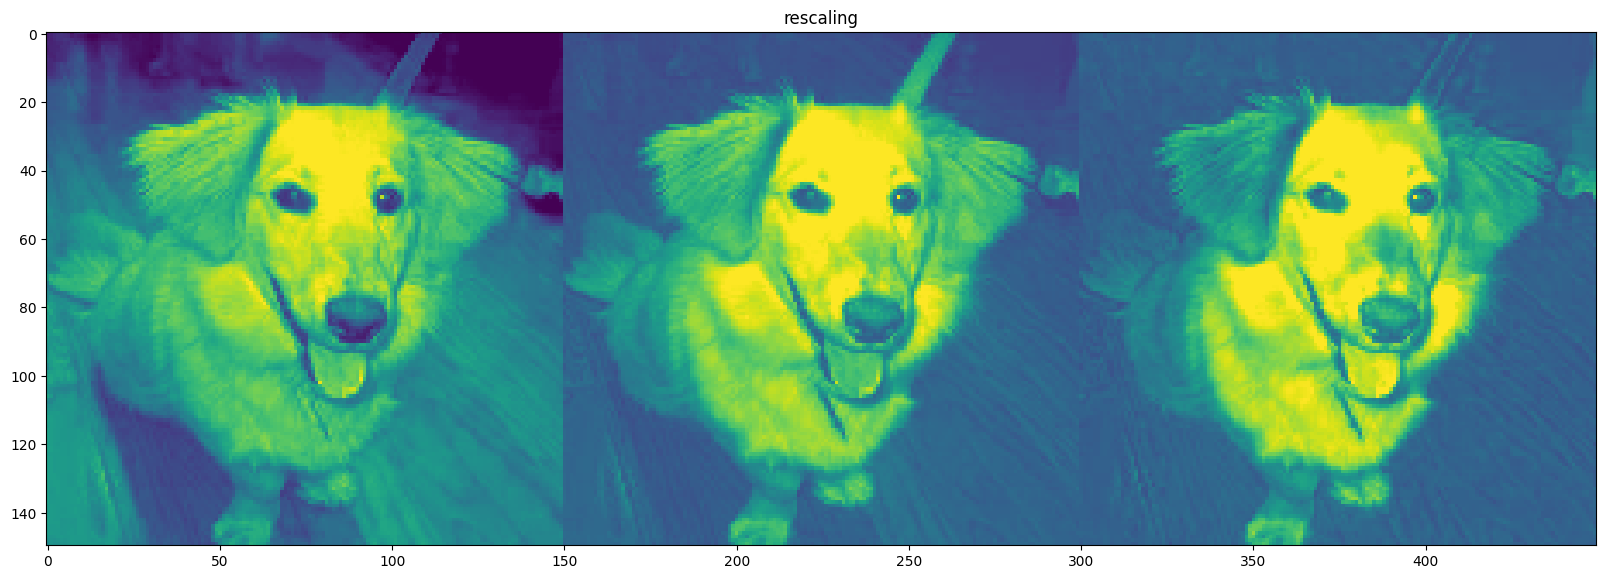

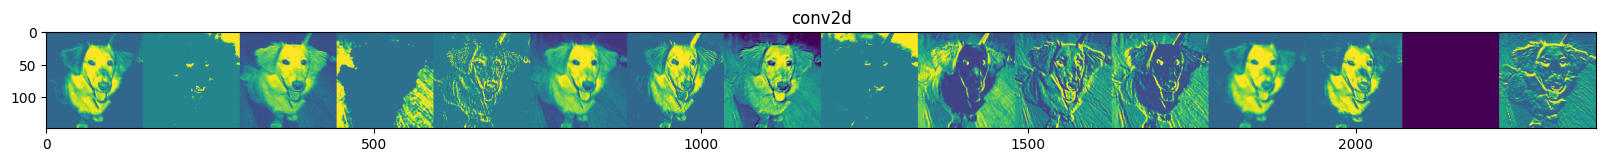

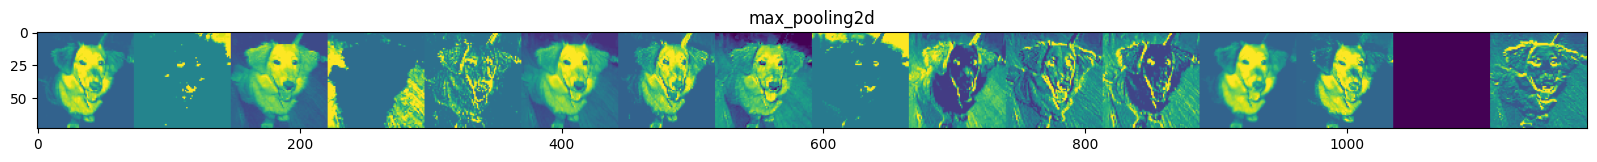

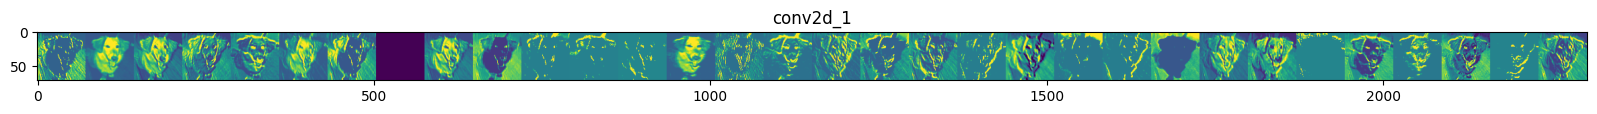

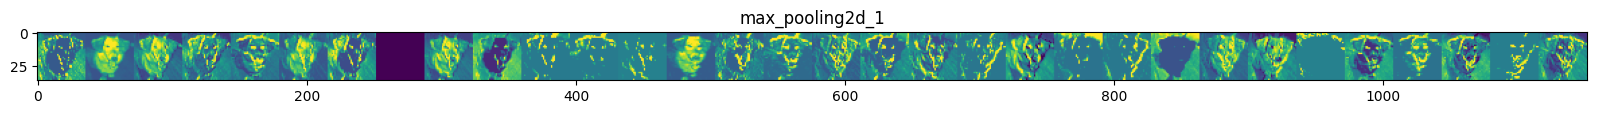

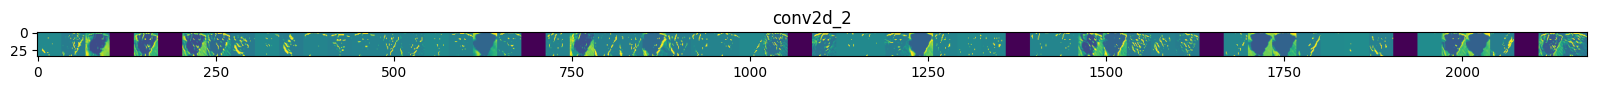

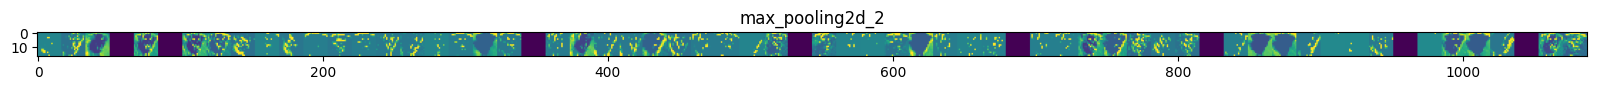

In [ ]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.inputs, outputs = successive_outputs)

# Prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = tf.keras.utils.load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = tf.keras.utils.img_to_array(img) # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape) # Numpy array with shape (1, 150, 150, 3)

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

    if len(feature_map.shape) == 4:

        #-------------------------------------------
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        #-------------------------------------------
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size = feature_map.shape[1]  # feature map shape (1, size, size, n_features)

        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))

        #-------------------------------------------------
        # Postprocess the feature to be visually palatable
        #-------------------------------------------------
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

        #-----------------
        # Display the grid
        #-----------------
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

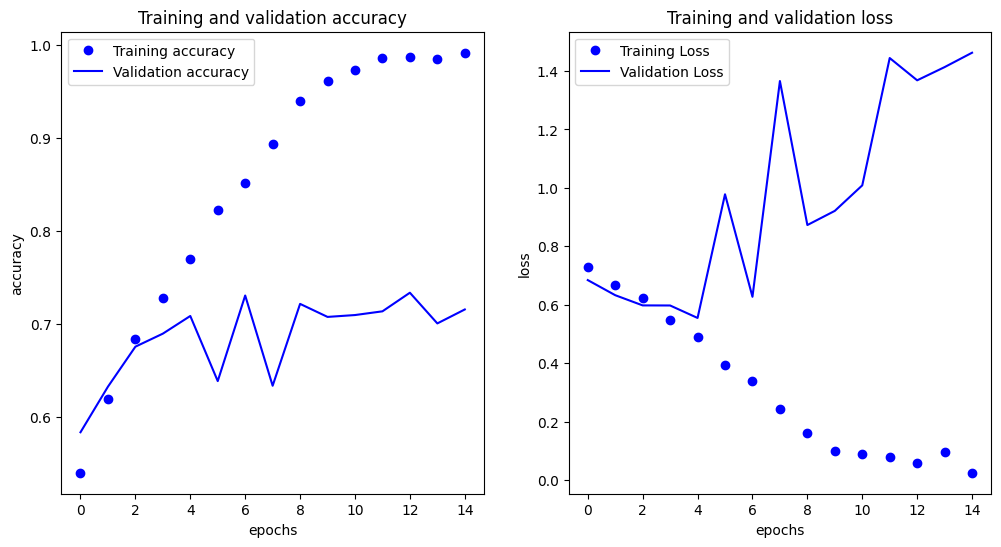

In [ ]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

plot_loss_acc(history)